# 横浜気象情報と釣果の分析

In [1]:
# モジュールのインポート

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
import jpholiday
import sqlite3
import seaborn as sns

# グラフサイズ変更。既定より大きくする

plt.rcParams['figure.figsize'] = [15, 10]

# seaborn グラフにグリッド線を追加

sns.set()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

In [43]:
conn = sqlite3.connect("../fishing_result.db")
sql = '''
select
    r.Date,
    r.Count,
    r.SizeMin,
    r.SizeMax,
    c.WaterTemp,
    c.Quantity,
    w.TempAve,
    w.TempMax,
    w.TempMin,
    w.RainMm,
    w.WinMsAve,
    w.WinMsMax,
    w.hPA
from
    fishing_results r,
    fishing_comments c,
    weathers w
where
    r.Date = c.Date
    and r.Point = c.Point
    and r.Species = 'アジ'
    and r.Point = 'Daikoku'
    and r.Date = w.Date
'''

df=pd.read_sql_query(sql, conn)
df['Date'] = pd.to_datetime(df.Date)
df = df.set_index('Date')
df.head()

,Count,SizeMin,SizeMax,WaterTemp,Quantity,TempAve,TempMax,TempMin,RainMm,WinMsAve,WinMsMax,hPA
Date,,,,,,,,,,,,
2021-04-02,147.0,10.0,25.0,16.0,289.0,7.7,12.3,3.1,0.0,4.3,10.9,4.4
2021-04-01,134.0,13.0,25.0,16.0,232.0,6.7,11.0,2.7,0.0,2.2,4.6,5.2
2021-03-31,130.0,15.0,25.0,15.5,298.0,17.9,21.6,15.5,0.0,3.1,6.5,11.4
2021-03-30,192.0,15.0,20.0,15.0,305.0,18.1,23.1,14.9,0.0,2.4,4.6,15.3
2021-03-29,42.0,13.0,17.0,14.0,299.0,17.7,22.8,13.6,56.0,3.5,7.3,15.6


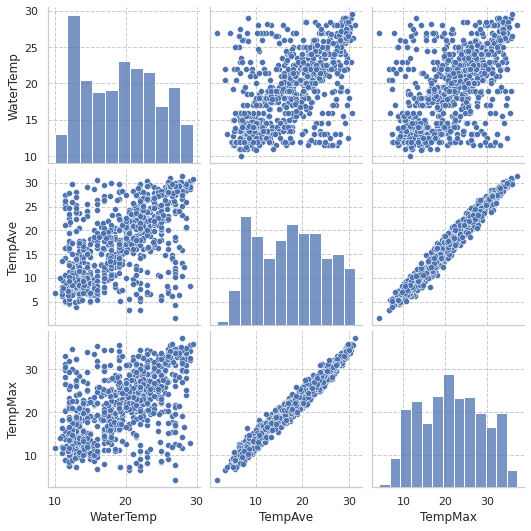

In [58]:
# 散布図、気温
df2 = df[['WaterTemp', 'TempAve', 'TempMax']]
sns.pairplot(df2)

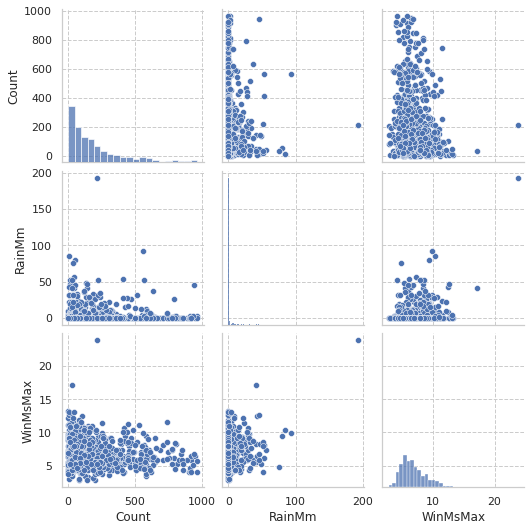

In [59]:
# 散布図、気温
df2 = df[['Count', 'RainMm', 'WinMsMax']]
sns.pairplot(df2)

In [54]:
# 土日祝日化判定列を追加

def isBizDay(Date):
    if Date.weekday() >= 5 or jpholiday.is_holiday(Date):
        return 'Holiday'
    else:
        return 'WeekDay'


In [55]:
# seaborn でプロットしやすいようにデータフレームを横縦変換する
df2 = df[[
'Count','SizeMin','SizeMax','WaterTemp','Quantity',
'TempAve', 'TempMax', 'TempMin', 'RainMm', 'WinMsAve', 'WinMsMax', 'hPA']]

df2 = df2.stack().reset_index()
df2 = df2.rename(columns={'level_1': 'Metric', 0: 'Value'})

# 平日、休日判定列を追加

df2['BizDay'] = df2.apply(lambda x: isBizDay(x.Date), axis=1)

# 日付を索引にセットして、各年月日列を追加

df3 = df2.set_index('Date')
df3['Year'] = df3.index.year
df3['Month'] = df3.index.month
df3['DayOfYear'] = df3.index.dayofyear
df3['WeekOfYear'] = df3.index.strftime('%U').astype(int) # df3.index.week
df3.head()

,Metric,Value,BizDay,Year,Month,DayOfYear,WeekOfYear
Date,,,,,,,
2021-04-02,Count,147.0,WeekDay,2021,4,92,13
2021-04-02,SizeMin,10.0,WeekDay,2021,4,92,13
2021-04-02,SizeMax,25.0,WeekDay,2021,4,92,13
2021-04-02,WaterTemp,16.0,WeekDay,2021,4,92,13
2021-04-02,Quantity,289.0,WeekDay,2021,4,92,13


<AxesSubplot:xlabel='Month', ylabel='Value'>

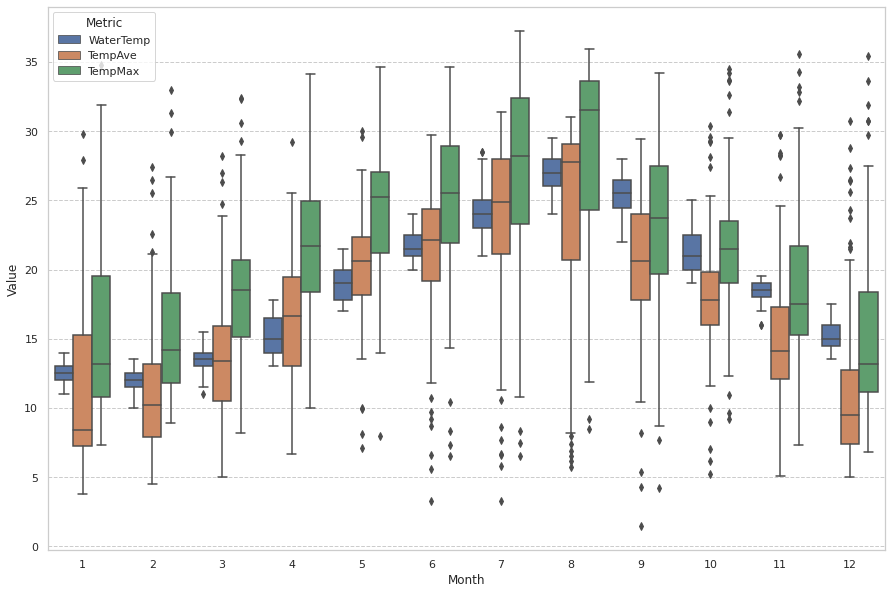

In [56]:
df6 = df3.loc[df3['Metric'].isin(['WaterTemp', 'TempAve', 'TempMax'])]
sns.boxplot(data = df6, x="Month", y="Value", hue="Metric")

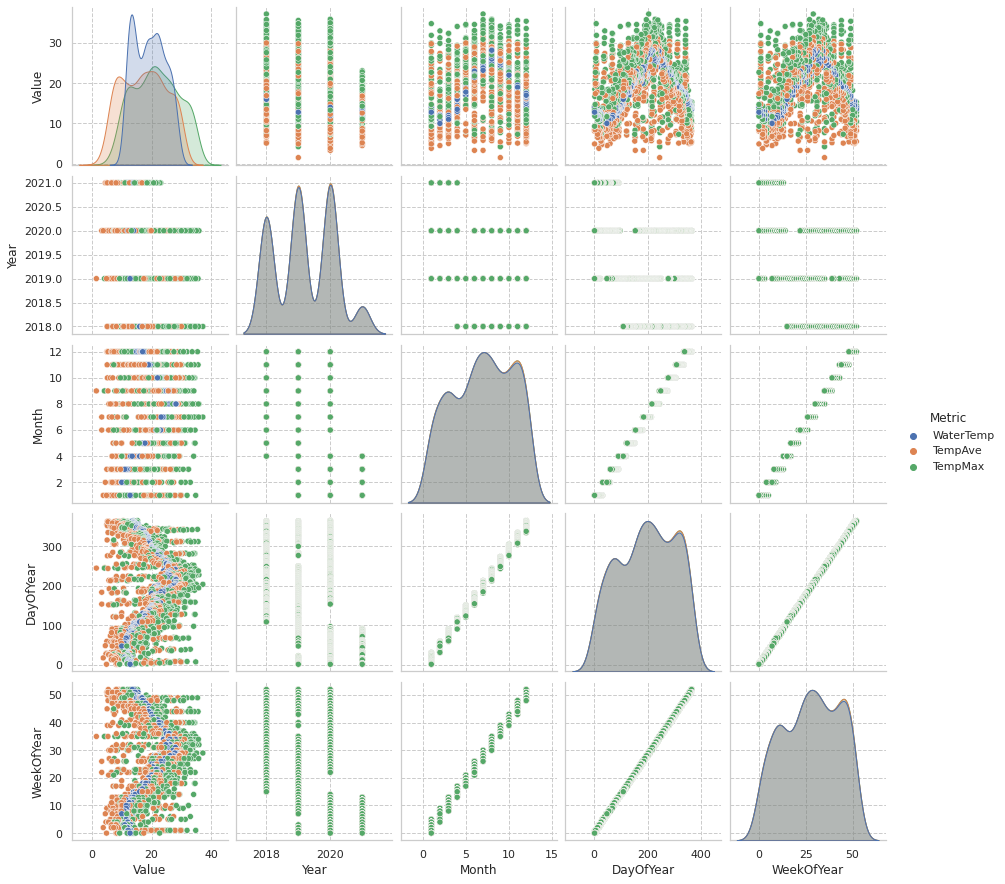

In [57]:
# 日付を索引にセットして、各年月日列を追加

df6 = df3.loc[df3['Metric'].isin(['WaterTemp', 'TempAve', 'TempMax'])]
sns.pairplot(df6, hue="Metric")

In [13]:
df3.count()

Metric        10066
Value         10066
BizDay        10066
Year          10066
Month         10066
DayOfYear     10066
WeekOfYear    10066
dtype: int64

In [20]:
import numpy as np
# df4 = df3[df3.Value.apply(lambda x: x.isnumeric())]
df4 = df3[df3['Value'].apply(lambda x: type(x) in [int, np.int64, float, np.float64])]    
df4.head()

,Metric,Value,BizDay,Year,Month,DayOfYear,WeekOfYear
Date,,,,,,,
2021-04-02,Count,147,WeekDay,2021,4,92,13
2021-04-02,SizeMin,10,WeekDay,2021,4,92,13
2021-04-02,SizeMax,25,WeekDay,2021,4,92,13
2021-04-02,WaterTemp,16,WeekDay,2021,4,92,13
2021-04-02,Quantity,289,WeekDay,2021,4,92,13


DataError: No numeric types to aggregate

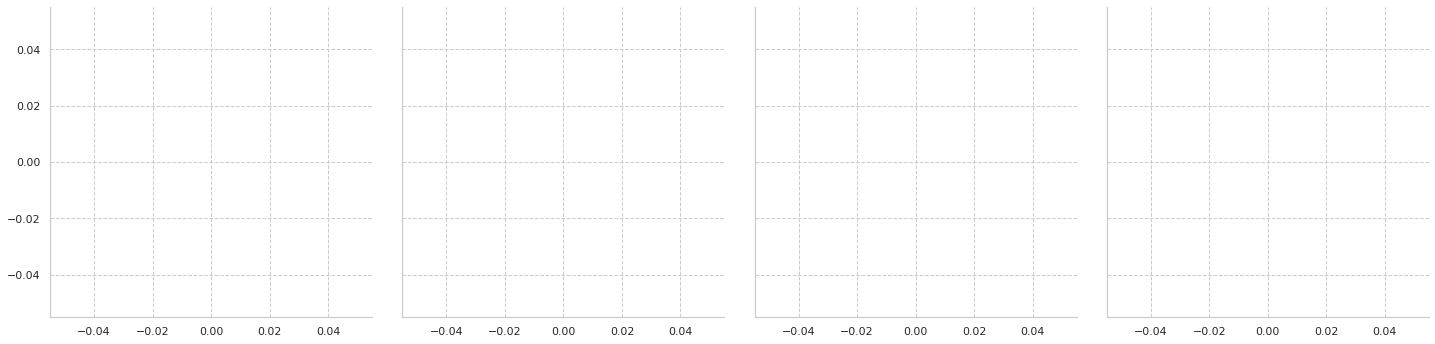

In [19]:
#df4 = df3.loc[df3['Metric'].isin(['WaterTemp', 'TempAve', 'TempMax'])]
sns.relplot(data=df4, x='Month', y='Value', hue='Metric', col='Year', kind="line")